In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import spearmanr

# Первый файл 

In [2]:
data_1 = np.loadtxt("C:/Users/fourz/Downloads/1.txt", delimiter=',', dtype=np.float64)
df = pd.DataFrame(data_1, columns= ["X", "Y"])
df.head()

,X,Y
0,5.000000,5.898558
1,5.202020,6.775998
2,5.404040,7.615025
3,5.606061,8.414141
4,5.808081,7.946979


### Описательная статистика 

In [3]:
df.describe()

,X,Y
count,100.000000,100.000000
mean,15.000000,30.549274
std,5.860907,13.076907
min,5.000000,5.898558
25%,10.000000,20.289819
50%,15.000000,29.738269
75%,20.000000,41.713283
max,25.000000,53.679608


### Глянуть на данные оценить их визульно 

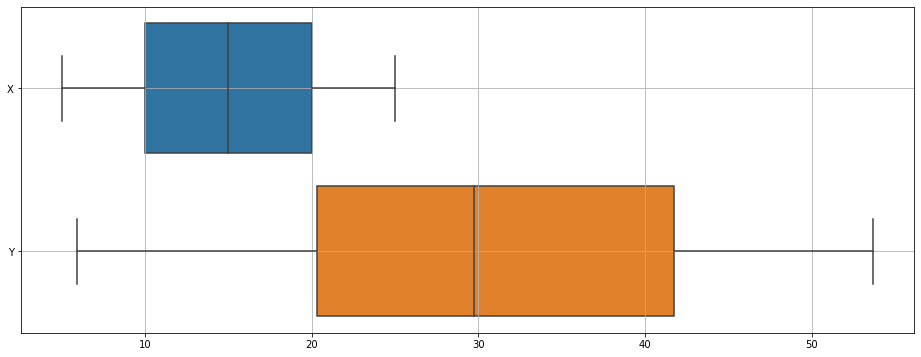

In [4]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, orient="h")
plt.grid()


### Посчитать коэффициент детерминации. Чем ближе |𝑟(𝑥, 𝑦)| к 1, тем теснее связь между исследуемыми величинами.


In [5]:
cc = df[["X", "Y"]].corr()
print(cc.Y.X**2)
#Рассчитаем связь между величинами по вычисленным описательным статистикам по формуле выше для
#𝑟(𝑥, 𝑦). Полученное значение корреляции 𝑟(𝑥, 𝑦) ≈ 0.973, что говорит о сильной линейной связи между
#переменными. По шкале Чеддока данная связь характеризуется как весьма высокая.

0.9731766609573025


### Также оценим значимость коэффициента с помощью проверки по следующему критерию. Рассчитаем 𝑡-статистику для данного ряда данных и коэффициента линейной корреляции:

In [6]:
t_stat = abs(cc.Y.X ** 2) * np.sqrt((len(df) - 2) / 1 - (cc.Y.X ** 2) ** 2)
t_stat
# H0 <= 1.98
# H1 > 1.98
#Из значений 𝑡-Статистики видно, что уровень значимости преодолен, и значение коэффициента линейной корреляции
#Пирсона значительно отличается от нуля и его значение является статистически значимым.

9.587293090460646

### Построить доверительный интервал для 𝑟(𝑥, 𝑦) с надежностью 𝛾 = 0.95

In [7]:
d = (1 - cc.Y.X ** 2) / len(df) # Погрешность 
c = np.array([-1, 1])
CIR = cc.Y.X ** 2 + c * d * 1.98 # расчет доверительного интервала 
CIR

array([0.97264556, 0.97370776])

In [8]:
def RSS(df, result):
    R = (df.Y - result.predict()) ** 2
    return R.sum()
#Понадобится для прогнознах интервалов и для теста чоу 

### Построение и подгонка линейной модели 

In [9]:
model = sm.OLS.from_formula("Y ~ X", data = df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     3556.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           8.09e-79
Time:                        12:44:55   Log-Likelihood:                -217.55
No. Observations:                 100   AIC:                             439.1
Df Residuals:                      98   BIC:                             444.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4669      0.594     -4.153      0.000      -3.646      -1.288
X              2.2011      0.037     59.628      0.000       2.128       2.274
==============================================================================
Omnibus:                        0.124   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.155
Skew:                           0.079   Prob(JB):                        0.926
Kurtosis:                       2.891   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Оценка адекватности оцененной модели регрессии. Определение F-критерия

In [10]:
def fisher_test(df, result):
    
    RSS = sum((df.Y - result.predict()) ** 2)/ (len(df) - 2) # Это не совсем RSS так просто назвал
    TSS = sum((df.Y - df.Y.mean()) ** 2)/ (len(df) - 1)
    F = RSS / TSS
    
    if F > 0.05: # На самом деле тут не 0.05 а число по таблице, но я не нашел функцию которая считает критические значения поэтому оставил 0.05 
        print("\n", "Расчетная статистка значительно больше кретического значения распредления фишера, Принимаем H1",
              "\n", "Модель признается НЕ адекватной ",)
    else:
        print("\n", "Расчетная статистка значительно больше кретического значения распредления фишера, Остаемся с H0",
              "\n", "Модель адекватна ")
    return F
fisher_test(df, result)


 Расчетная статистка значительно больше кретического значения распредления фишера, Остаемся с H0 
 Модель адекватна 


0.027097046583949083

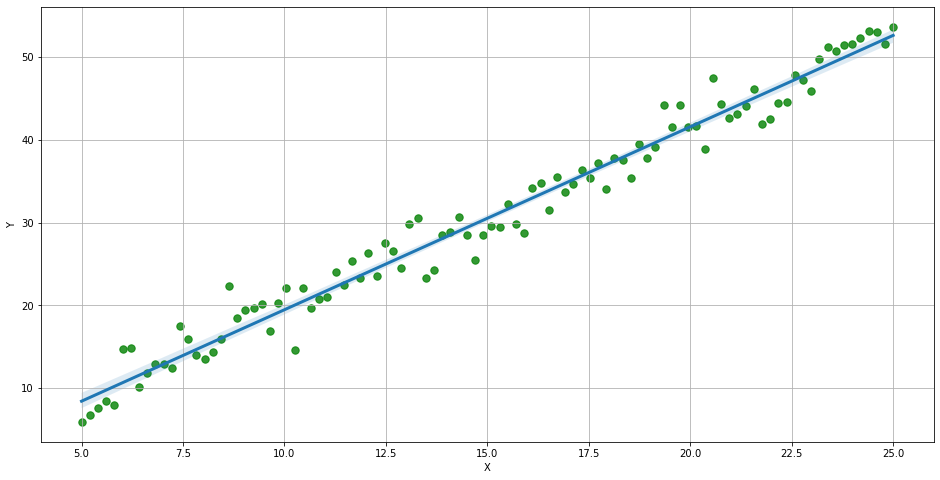

In [11]:
plt.figure(figsize=(16, 8))
sns.regplot(
    x=df.X, 
    y=df.Y, 
    data=df,
    robust=True,
    scatter_kws={"s": 55, 'color': 'g'}, 
    line_kws={"lw":3}
)
plt.grid()

## Расчет "margin of error"

In [12]:
y = result.params[0] + result.params[1] * 15 # Выберем какое нибудь значение для прогноза например 
t = 1.9844675
SQRT = np.sqrt(1 + 1 /len(df) + ((15 - df.X.mean()) ** 2)/ len(df) * df.X.std() ** 2) # Супервыебанная формула 
E = t * (RSS(df, result) / len(df) - 2) * SQRT

## Оценка прогнозного интервала для линейной модели регрессии

In [13]:
# Доверительный интервал строится: Лучшая оценка +- погрешщность (margin of error)
CII = y + c * E
CII

array([25.48145496, 35.61709401])

# Второй файл 

In [14]:
data_3 = np.loadtxt("C:/Users/fourz/Downloads/3.txt", delimiter=',', dtype=np.float64)
df3 = pd.DataFrame(data_3, columns= ["X", "Y"])
df3.head()

,X,Y
0,5.000000,14.728427
1,5.202020,-2.531906
2,5.404040,2.785172
3,5.606061,3.829840
4,5.808081,-18.097788


## Описательная статистика 

In [15]:
df3.describe()

,X,Y
count,100.000000,100.000000
mean,15.000000,29.398876
std,5.860907,40.865088
min,5.000000,-138.431106
25%,10.000000,2.693601
50%,15.000000,24.598001
75%,20.000000,48.048078
max,25.000000,159.800494


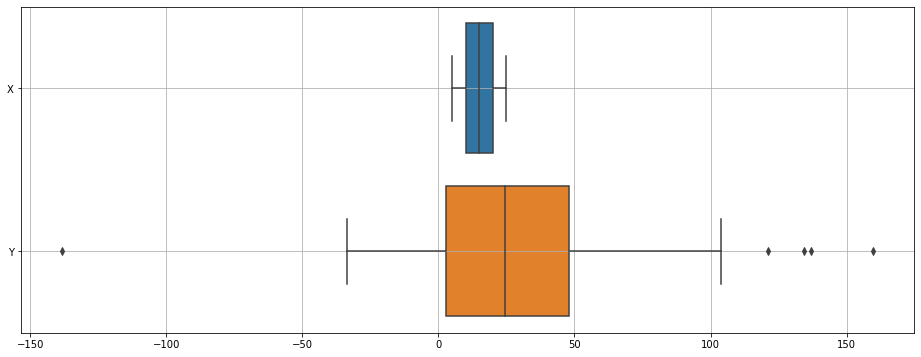

In [16]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df3, orient="h")
plt.grid()

In [17]:
model3 = sm.OLS.from_formula("Y ~ X", data=df3)
result3 = model3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     8.659
Date:                Sat, 03 Dec 2022   Prob (F-statistic):            0.00406
Time:                        12:45:04   Log-Likelihood:                -508.19
No. Observations:                 100   AIC:                             1020.
Df Residuals:                      98   BIC:                             1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4012     10.865     -0.037      0.971     -21.963      21.161
X              1.9867      0.675      2.943      0.004       0.647       3.326
==============================================================================
Omnibus:                       22.453   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.350
Skew:                          -0.528   Prob(JB):                     3.25e-21
Kurtosis:                       7.640   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

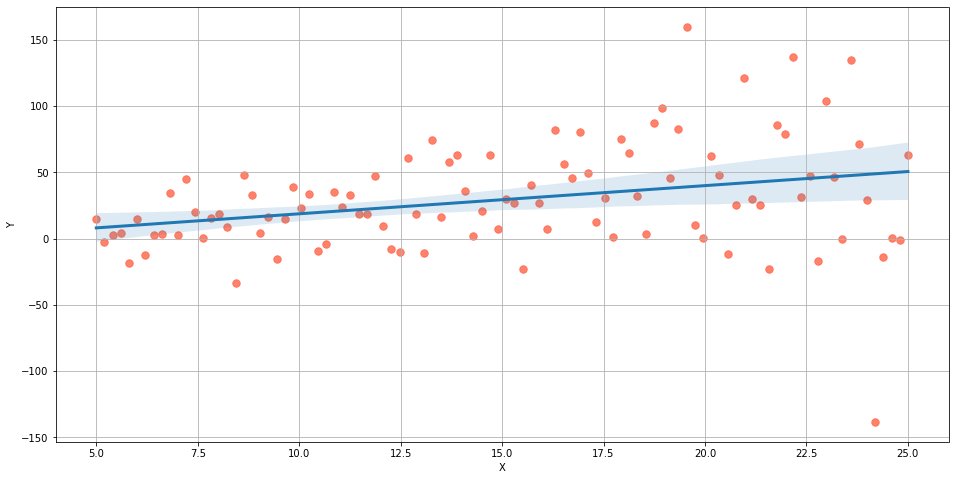

In [18]:
plt.figure(figsize=(16, 8))
sns.regplot(
    x=df3.X,
    y=df3.Y,
    data=df3,
    robust=True,
    scatter_kws={"s": 55, 'color': '#FF6347'},
    line_kws={"lw":3}
)
plt.grid()

# Тест на гетероскедастичность Голдфелда−Куандта
* **H0: Присутствует гомоскедастичность**
* **H1: гетероскедастичность присутствует**

In [40]:
def homoscedasticity_test(model):
    
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')
    plt.figure(figsize=(7, 7))

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')


    gq_test = pd.DataFrame(sm.stats.diagnostic.het_goldfeldquandt(resids, model.model.exog, drop=0.2)[:-1],
                           index=['F statistic', 'p-value'])

    print('\n Тест Голдфелда−Куандта ----')
    print(gq_test)
    print('\n График остатков ---------')



 Тест Голдфелда−Куандта ----
                        0
F statistic  7.078043e+00
p-value      2.483698e-07

 График остатков ---------


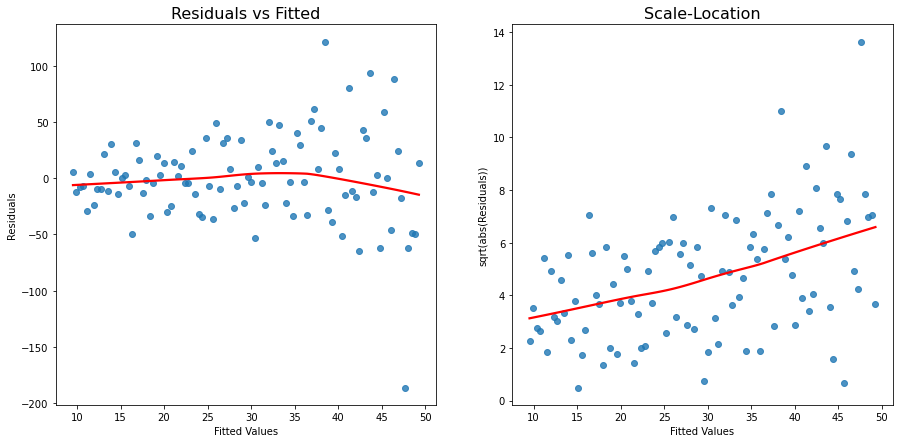

<Figure size 504x504 with 0 Axes>

In [20]:
homoscedasticity_test(result3)
# Исходя из F-статистики мы склонны лтвергнуть H0 т к наш уровень значимости значительно выше интервала где мы склонны принять H0
# Простыми словами мы отвергаем H0 потому что наше F-statistic > F-tables, F-tables = 4 с чем то хз

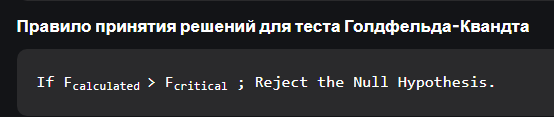

# Построил еще одну модель на всякий случай ибо не понятно было почему такой плохой коэффициент Детерминации при неплохом графике

In [21]:
X = np.array(df3.X)
Y = np.array(df3.Y)

X = X.reshape(-1,1)
print(X.shape)

Y = Y.reshape(-1,1)
print(Y.shape)

(100, 1)
(100, 1)


In [22]:
from sklearn.linear_model import LinearRegression

SimpleLinearRegg = LinearRegression(fit_intercept= True)
SimpleLinearRegg.fit(X, Y)
print('Linear Model Coeff(b1)', SimpleLinearRegg.coef_)
print('Linear Model Coeff(b0)', SimpleLinearRegg.intercept_)
# Абсолютно такие же коэфициэнты 

Linear Model Coeff(b1) [[1.98667218]]
Linear Model Coeff(b0) [-0.4012067]


## Тест ранговой корреляции Спирмена на гетероскедастичность

In [23]:
# 1 - 6 * sum((df3['X'].rank() - eee.rank())**2) / (len(df3) * ((len(df3)**2) - 1))
# Это вручную считалось 

In [41]:
residual = df3["Y"] - result3.predict() # Остатки 
def spearmans_rank_correlation(x, y):
    # Расчитаем ранг для Х
    xranks = pd.Series(x).rank()
      
    # Расчитаем ранг для остатков 
    yranks = pd.Series(y).rank()
    
    print("Коэффициент ранговой корреляции Спирмена:",  spearmanr(xranks, yranks)[0])
    print("p-значение ранговой корреляции",  spearmanr(xranks, yranks)[1])
    
    if spearmanr(xranks, yranks)[0]*np.sqrt(len(df3)-1) > 1.96:
        print("Гетероскедастичность признается значимой. Гипотеза 𝐻1 принимается")
    else:
        print("Гомоскедастичность признается значимой. Гипотеза 𝐻0 принимается")
    return

spearmans_rank_correlation(df3["X"], residual)
# прикол в том что у нас не может быть гомоскедостичности поэтому выше я на всякий расчитал вручную оказалось,

Коэффициент ранговой корреляции Спирмена: 0.016333633363336333
p-значение ранговой корреляции 0.8718622150141239
Гомоскедастичность признается значимой. Гипотеза 𝐻0 принимается


## Оценка адекватности оцененной модели регрессии. Определение F-критерия

In [42]:
fisher_test(df3, result3)


 Расчетная статистка значительно больше кретического значения распредления фишера, Принимаем H1 
 Модель признается НЕ адекватной 


0.9281903839615535

# Третий файл

In [26]:
data_2 = np.loadtxt("C:/Users/fourz/Downloads/2.txt", delimiter=',', dtype=np.float64)
df2 = pd.DataFrame(data_2, columns=["X", "D1", "D2", "Y"])
df2.head()

,X,D1,D2,Y
0,13.080808,0.0,1.0,6.597668
1,13.484848,0.0,1.0,8.037302
2,21.767677,0.0,1.0,12.798756
3,21.363636,1.0,0.0,-24.852641
4,5.202020,1.0,1.0,-7.292141


In [27]:
df2.describe()

,X,D1,D2,Y
count,200.000000,200.000000,200.000000,200.000000
mean,15.000000,0.500000,0.520000,-5.008261
std,5.846163,0.501255,0.500854,14.394640
min,5.000000,0.000000,0.000000,-29.202424
25%,10.000000,0.000000,0.000000,-18.135501
50%,15.000000,0.500000,1.000000,-2.172397
75%,20.000000,1.000000,1.000000,8.531451
max,25.000000,1.000000,1.000000,14.477634


# Строим 2 основных модели для теста Чоу

 **Основной прикол теста чоу это понять делить ли нашу выборку для построения нескольких линейных моделей или оставить все как есть**
 
* *ТО ЕСТЬ ВНИМАТЕЛЬНО СЕЙЧАС H0: наша выборка однородна и ее не нужно делить*
* *А H1: Говорит нам о неоднородности что предполагает строить 2 линейные модели*


In [28]:
cho_model1 = sm.OLS.from_formula("Y ~ X + D1", data=df2)
Cho_result1 = cho_model1.fit()
Cho_result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     757.5
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           3.18e-93
Time:                        12:45:15   Log-Likelihood:                -600.43
No. Observations:                 200   AIC:                             1207.
Df Residuals:                     197   BIC:                             1217.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8100      1.019     11.594      0.000       9.801      13.819
X             -0.2250      0.060     -3.781      0.000      -0.342      -0.108
D1           -26.8868      0.694    -38.740      0.000     -28.256     -25.518
==============================================================================
Omnibus:                       60.583   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.502
Skew:                          -0.033   Prob(JB):                      0.00524
Kurtosis:                       1.879   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Построение линейной модели по первому коэффициенту "D1"

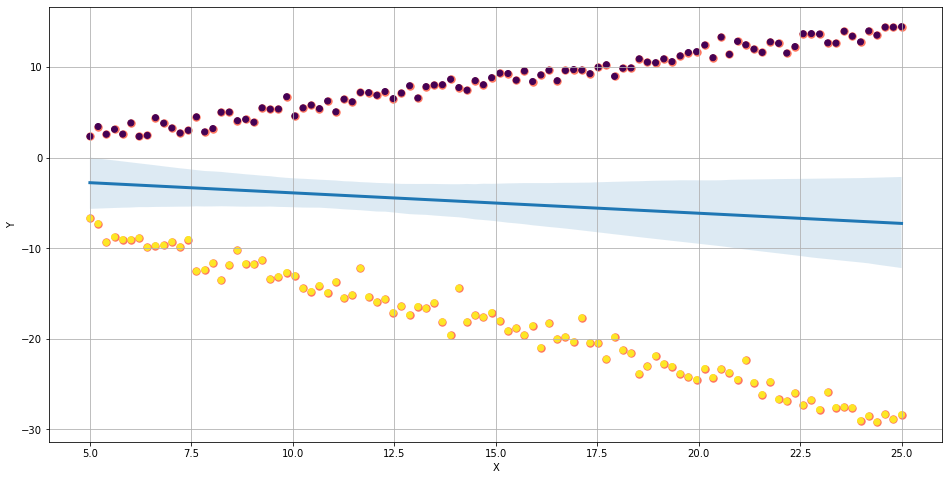

In [29]:
plt.figure(figsize=(16, 8))

sns.regplot(
    x=df2.X,
    y=df2.Y,
    data=df2,
    robust=True,
    scatter_kws={"s": 55, 'color': '#FF6347'},
    line_kws={"lw":3}
)
plt.scatter(df2['X'], df2['Y'], c=df2['D1'])
plt.grid()


In [31]:
cho_model2 = sm.OLS.from_formula("Y ~ X + D2", data=df2)
Cho_result2 = cho_model2.fit()
Cho_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.467
Date:                Sat, 03 Dec 2022   Prob (F-statistic):              0.233
Time:                        12:52:31   Log-Likelihood:                -815.18
No. Observations:                 200   AIC:                             1636.
Df Residuals:                     197   BIC:                             1646.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0268      3.146     -0.009      0.993      -6.231       6.177
X             -0.2521      0.176     -1.434      0.153      -0.599       0.095
D2            -2.3069      2.052     -1.124      0.262      -6.354       1.740
==============================================================================
Omnibus:                     2626.137   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.123
Skew:                          -0.006   Prob(JB):                     4.27e-05
Kurtosis:                       1.446   Cond. No.                         53.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Построение линейной модели по первому коэффициенту "D2"

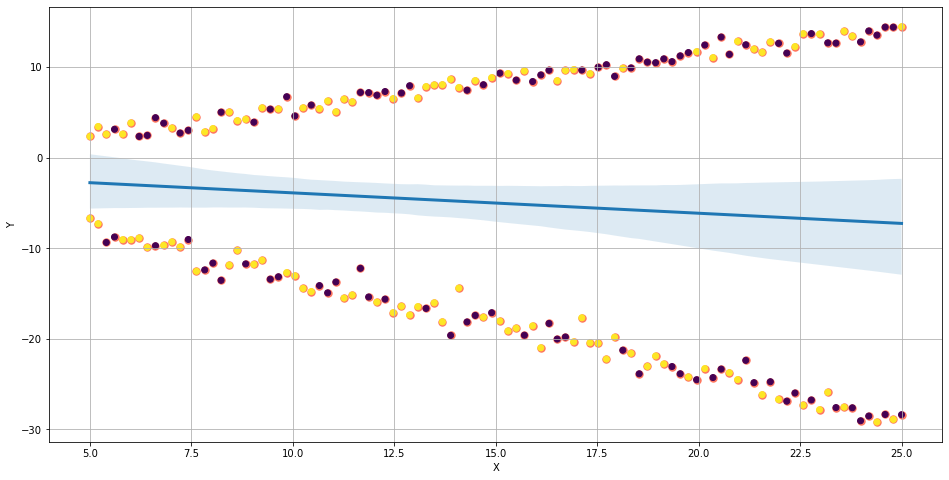

In [32]:
plt.figure(figsize=(16, 8))

sns.regplot(
    x=df2.X,
    y=df2.Y,
    data=df2,
    robust=True,
    scatter_kws={"s": 55, 'color': '#FF6347'},
    line_kws={"lw":3}
)
plt.scatter(df2['X'], df2['Y'], c=df2['D2'])
plt.grid()

In [39]:
def F_chow(data, x, Cho_result):
    Cho_df1_0 = data[x == 0]  #Разделил выборку "в этом и прикол этого теста"
    Cho_df1_1 = data[x == 1]
    
    cho_model0 = sm.OLS.from_formula("Y ~ X + D2", data=Cho_df1_0) # Линейная модель для данных где коэффициэнт D равен "0"
    cho_result0 = cho_model0.fit()
    
    cho_model1 = sm.OLS.from_formula("Y ~ X + D2", data=Cho_df1_1) # Линейная модель для данных где коэффициэнт D равен "1"
    cho_result1 = cho_model1.fit()
    
    F = (RSS(df2, Cho_result) - (RSS(Cho_df1_0, cho_result0) + RSS(Cho_df1_1, cho_result1))) * len(Cho_df1_1) - 4
    GG = F / ((RSS(Cho_df1_0, cho_result0) + RSS(Cho_df1_1, cho_result1))) * 4
    
    return GG
F_chow(df2, df2.D2, Cho_result2)

0.55208583933589

## Eсли наша F-статистика > Табличной F, тогда мы отверагем нулевую гипотезу об однородности выборки. (H1)
## Eсли F-статистика < Табличной F, тогда мы остаемся с нулевой гипотезой (H0)

In [38]:
lone1 = df2[df2["D1"] == 0]
lone2 = df2[df2["D1"] == 1]
MODEL1 = sm.OLS.from_formula("Y ~ X + D1", data=lone2)
Result1 = MODEL1.fit()
Result1.summary()

C:\Users\fourz\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3695.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           1.29e-79
Time:                        12:55:48   Log-Likelihood:                -141.43
No. Observations:                 100   AIC:                             286.9
Df Residuals:                      98   BIC:                             292.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3649      0.139     -9.837      0.000      -1.640      -1.090
X             -1.0481      0.017    -60.788      0.000      -1.082      -1.014
D1            -1.3649      0.139     -9.837      0.000      -1.640      -1.090
==============================================================================
Omnibus:                       10.379   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.504
Skew:                           0.610   Prob(JB):                      0.00318
Kurtosis:                       4.128   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

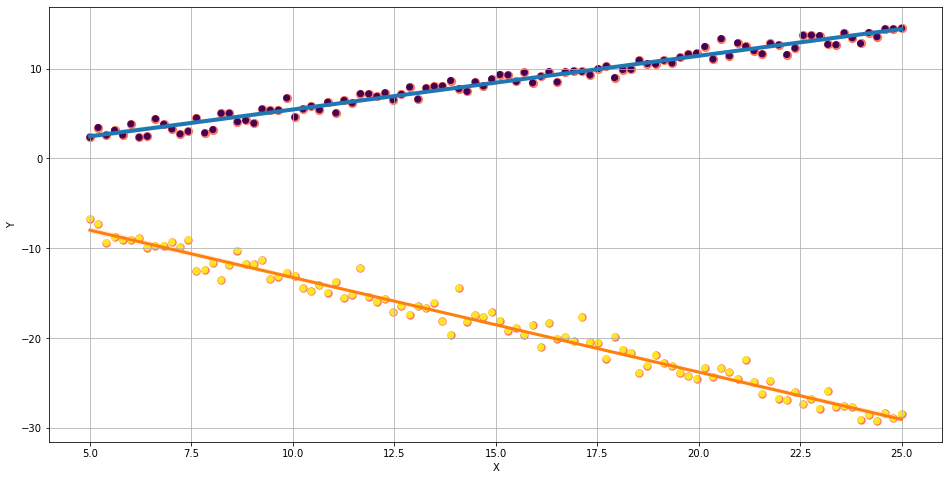

In [24]:
plt.figure(figsize=(16, 8))
sns.regplot(
    x=lone1.X,
    y=lone1.Y, 
    data=lone1,
    robust=True,
    ci=95,
    scatter_kws={"s": 68, 'color': '#FF6347'},
    line_kws={"lw":4}
)

sns.regplot(
    x=lone2.X,
    y=lone2.Y, 
    data=lone2,
    robust=True,
    ci=95,
    scatter_kws={"s": 55, 'color': '#FF6347'},
    line_kws={"lw":3}
)
plt.scatter(df2['X'], df2['Y'], c=df2['D1'])
plt.grid()